<a href="https://colab.research.google.com/github/hyesungKomet/deep_learning/blob/main/ch4_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 마운트

In [ ]:
%cd /content/drive/MyDrive/machine_learning

import numpy as np


/content/drive/MyDrive/machine_learning


In [ ]:
%cd deep-learning-from-scratch-2

/content/drive/MyDrive/machine_learning/deep-learning-from-scratch-2


# 4.1

# Embedding
단어 ID에 해당하는 행 추출하는 계층
입력층의 원핫 표현의 MatMul 계층 문제 -> 해결 by Embedding 계층

In [ ]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dw, = self.grads
    dw[...] = 0
    '''
    for i, word_id in enumerate(self.idx): #같은 idx가 할당되어 중복되는 경우 따져주기 위해서 중첩시킨다
      dw[word_id] += dout[i]
    '''
    # or
    np.add.at(dW, self.idx, dout) #위의 for문과 같은 의미 but numpy의 최적화로 더 빠름
    # np.add.at(a,idx,b) : a의 idx번째 행에 b를 더한다

    return None

# 4.2

# Negative Sampling
은닉층 이후의 병목현상에 대한 처리
softmax대신 negative sampling 사용
* 은닉층 뉴런과 W_out과의 곱 --> (특정 단어에 해당하는 열만 추출하여 내적으로 계산)
* Softmax 계층 계산 --> 다중분류를 이중분류로(Softmax -> Sigmoid)

In [ ]:
class EmbeddingDot: #EmbeddingDot은 Embedding계층과 이를 가중치와 곱하는 Dot계층을 합한 것
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None #forward 계산결과 잠시 유지용 변수

  def forward(self, h, idx): #h: 은닉층 뉴런 idx: 단어id의 numpy 배열 - 미니배치 처리를 가정했기에 배열이다
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis = 1) //내적 계산

    self.cache = (h, target_W)
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)

    dtarget_W = dout*h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh
  

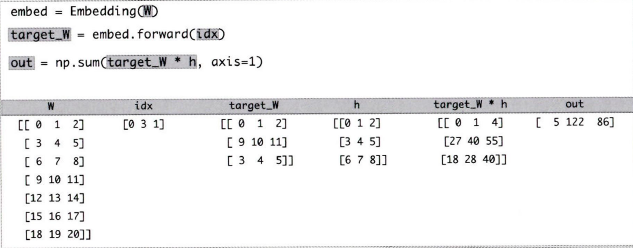

위의 그림을 보면 forward에서의 np.sum(self.target_W*h, axis=1)이 이해가 될 것이다

지금까지는 이진분류 중 정답인 레이블에 대해서 구현한 것이다
이제 오답인 경우에 점수 또는 확률이 작게 나오도록 해야한다

이 때는 모든 오답을 다 해볼 수 없으니 Sampling으로 몇가지를 뽑아서 한다
* Samling 기준: 빈도 높을수록 뽑힐확률 높도록
* 정답에 대한 손실 + sampling한 오답에 대한 손실 == 최종 손실

## UnigramSampler 사용

In [ ]:
# np.randomo.choice(arr, size= n, replace = True, p=p)
# arr: 배열 size: 랜덤으로 추출할 개수 replace: 중복가능여부 p: 확률분포 배열

from ch04.negative_sampling_layer import UnigramSampler

In [ ]:
corpus = np.array([0,1,2,3,4,1,2,3]) # 단어 ID 목록
power = 0.75 #제곱할 값 - 희귀 단어 확률빈도 조금은 높여줌
sample_size = 2 # 샘플링할 횟수

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[2 0]
 [2 4]
 [2 1]]


In [ ]:
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size = 5):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [Embedding(W) for _ in range(sample_size + 1)]
    # sample_size + 1인 것은 부정적 예 sample_size개 + 정답 1개
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)

    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target) 
    #target: 긍정적 예 h: 은닉층 뉴런
    correct_label = np.ones(batch_size, dtype=np.int32) #1
    loss = self.loss_layers[0].forward(score, correct_label)

    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype = np.int32) #0
    for i in range(self.sample_size):
      negative_target = negative_sample[:,1]
      score = self.embed_dot_layers[1+i].forward(h, negative_target)
      loss += self.loss_layers[1+i].forward(score, negative_label)

    return loss

  def backward(self, dout=1): #각 층에서 backward호출하면 끝!
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)

    return dh